In [1]:
import kcorrect.kcorrect
import numpy as np
import sncosmo
from tqdm import tqdm
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
import sys
import json
import pandas as pd

tde_utils_location = '../'
sys.path.append(tde_utils_location)
from scripts import tde_utils

In [2]:
with open('../survey_master_list.json', 'r') as fp:
    survey_limits = json.load(fp)
    
roman_wide_limits = survey_limits['roman_wide_limits']
roman_deep_limits = survey_limits['roman_deep_limits']
roman_hour_limits = survey_limits['roman_1hour_limits']
roman_minute_limits = survey_limits['roman_1min_limits']
proposal_limits = survey_limits['roman_proposal_limits']

jwst_nircam_limits = survey_limits['jwst_nircam_10000s_limits']

at2018hyz = {'u_mag': 19.195, 'err_u': 0.034,
           'g_mag': 17.605, 'err_g': 0.005,
           'r_mag': 17.040, 'err_r': 0.005,
           'i_mag': 16.755, 'err_i': 0.005,
           'z_mag': 16.546, 'err_z': 0.0014,
            'z':  0.0457}

mag_dict = {'sdss_u0': (at2018hyz['u_mag'], at2018hyz['err_u']),
           'sdss_g0': (at2018hyz['g_mag'], at2018hyz['err_g']),
           'sdss_r0': (at2018hyz['r_mag'], at2018hyz['err_r']),
           'sdss_i0': (at2018hyz['i_mag'], at2018hyz['err_i']),
           'sdss_z0': (at2018hyz['z_mag'], at2018hyz['err_z'])}

gal = tde_utils.GalaxySource(mag_dict = mag_dict, obs_z = at2018hyz['z'])

In [38]:
zs = np.linspace(0.1, 15.5, 15)

tde_mags = {}
gal_mags = {}
snia_mags = {}
qso_mags = {}

for passband in jwst_nircam_limits.keys():
    tde_mags[passband] = np.zeros(len(zs))
    gal_mags[passband] = np.zeros(len(zs))
    snia_mags[passband] = np.zeros(len(zs))
    qso_mags[passband] = np.zeros(len(zs))

qso_source = tde_utils.QSOSource(r_mag = -25.)

In [ ]:
filter_loop = tqdm(list(tde_mags.keys()), total = len(list(tde_mags.keys()))*len(zs))

source = tde_utils.BlackBodySource(30000)
bb_model = sncosmo.Model(source=source)
qso_model = sncosmo.Model(source=qso_source)

for filt in filter_loop:
    print(filt)
    for i, z in enumerate(zs):
    
        luminosity_distance = cosmo.luminosity_distance(z)
        
        # TDE Magnitudes
        bb_model.set(z=z)

        tde_filter_zstretched_mag = bb_model.bandmag(filt, 'ab', 0)
        tde_app_mag = tde_filter_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
        tde_mags[filt][i] = tde_app_mag

#         # Galaxy Magnitudes

#         gal_model = sncosmo.Model(source=gal)
#         gal_model.set(z=z)
#         try:
#             gal_zstretched_mag = gal_model.bandmag(filt, 'ab', 0)
#             app_mag = gal_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
#             gal_mags[filt][i] = app_mag
#         except:
#             gal_mags[filt][i] = np.nan
        
#         # SNe Ia Magnitudes

#         snia_model = sncosmo.Model(source='salt2-extended')
#         snia_model.set(z=z)
#         snia_model.set(x1=0, c=0, x0= 1051627384124.3574, t0=0)
#         try:
#             snia_zstretched_mag = snia_model.bandmag(filt, 'ab', 0)
#             snia_app_mag = snia_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
#             snia_mags[filt][i] = snia_app_mag
#         except Exception as e:
#             #snia_mags[filt].append(np.nan)
#             print('simulating sn as blackbody')
#             snia_scale = 1.718e-16
#             snia_source = tde_utils.BlackBodySource(temperature=5500., scale=snia_scale)
#             snia_model = sncosmo.Model(source=snia_source)
#             snia_model.set(z=z)
            
#             snia_zstretched_mag = snia_model.bandmag(filt, 'ab', 0)
#             snia_app_mag = snia_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
#             snia_mags[filt][i] = snia_app_mag
            
        # QSO Magnitudes
        
        qso_model.set(z=z)
        try:
            qso_zstretched_mag = qso_model.bandmag(filt, 'ab', 0)
            qso_app_mag = qso_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
            qso_mags[filt][i] = qso_app_mag
        except:
            qso_mags[filt][i] = np.nan
            
        filter_loop.update()


for mag_dict in [tde_mags, gal_mags, snia_mags, qso_mags]:
    mag_dict['z'] = zs


  0%|                                                                       | 0/300 [00:00<?, ?it/s]

F070W


  6%|███▌                                                          | 17/300 [03:59<29:22,  6.23s/it]

F090W


  6%|███▋                                                          | 18/300 [05:02<55:59, 11.91s/it]

In [6]:
# tde_df = pd.DataFrame(tde_mags)
# tde_df.to_csv('./tde_mag_z.csv')

# gal_df = pd.DataFrame(gal_mags)
# gal_df.to_csv('./galaxy_mag_z.csv')

# snia_df = pd.DataFrame(snia_mags)
# snia_df.to_csv('./snia_mag_z.csv')

# qso_df = pd.DataFrame(qso_mags)
# qso_df.to_csv('./qso_mag_z.csv')

In [21]:
tde_df = pd.read_csv('./tde_mag_z.csv')
qso_df = pd.read_csv('./qso_mag_z.csv')
gal_df = pd.read_csv('./galaxy_mag_z.csv')

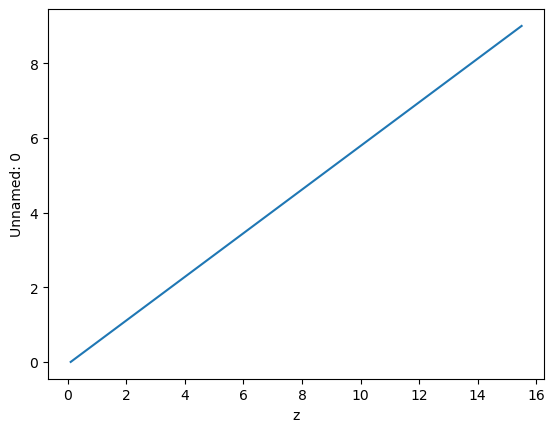

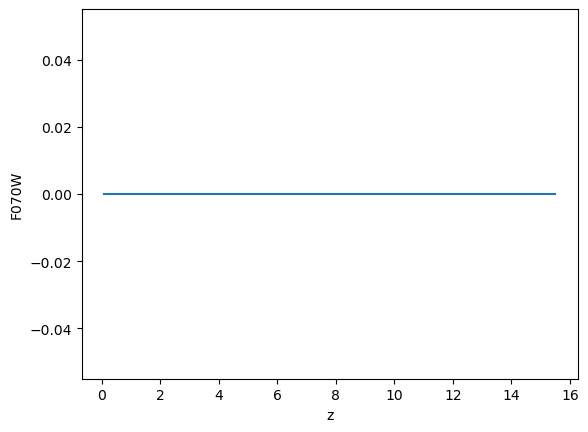

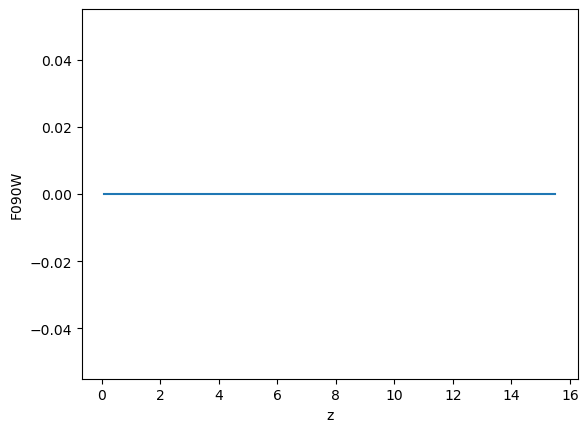

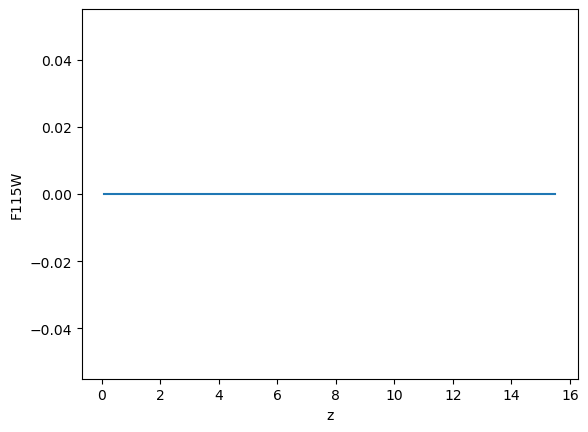

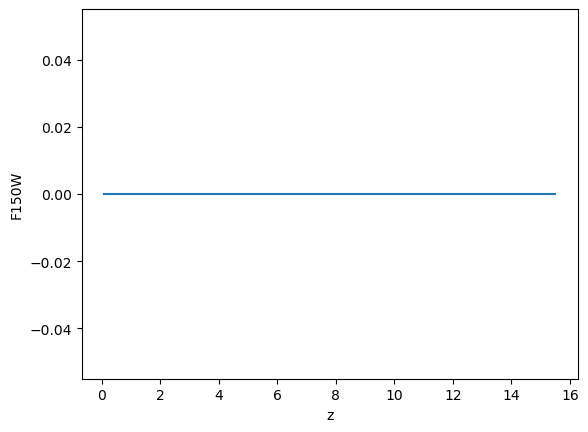

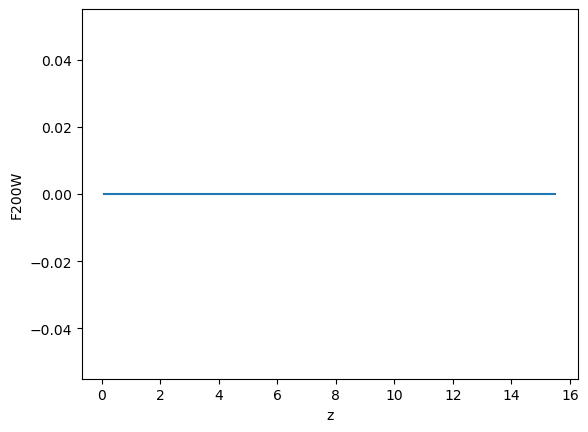

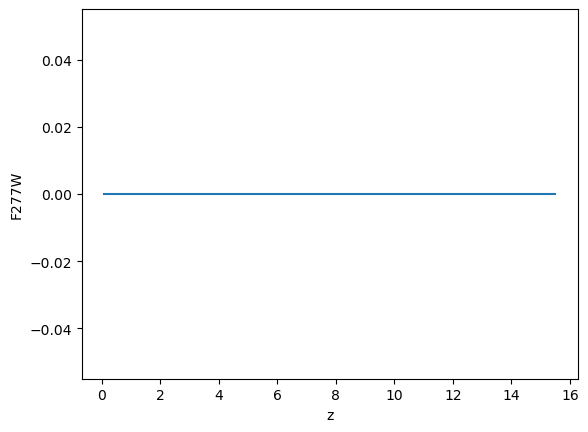

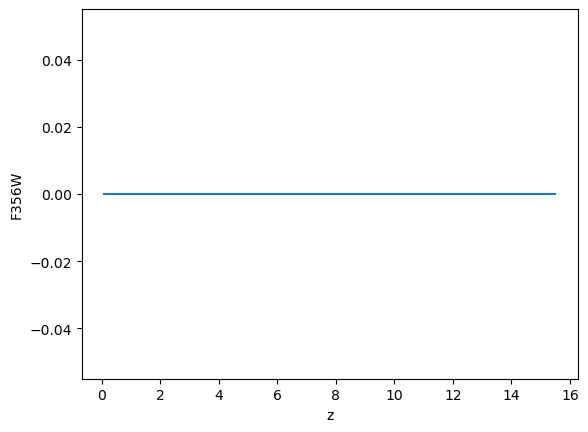

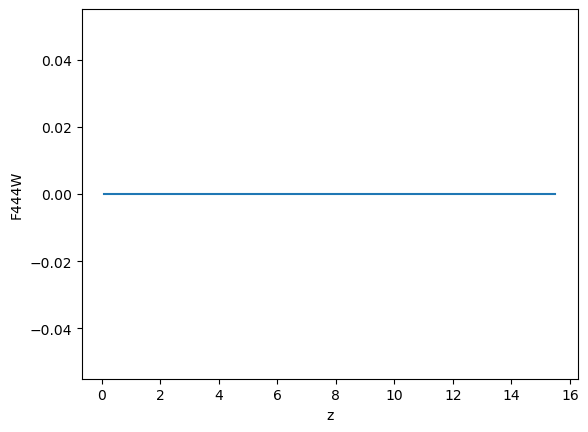

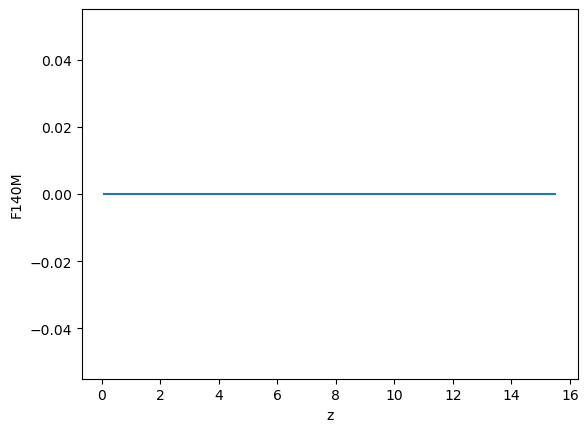

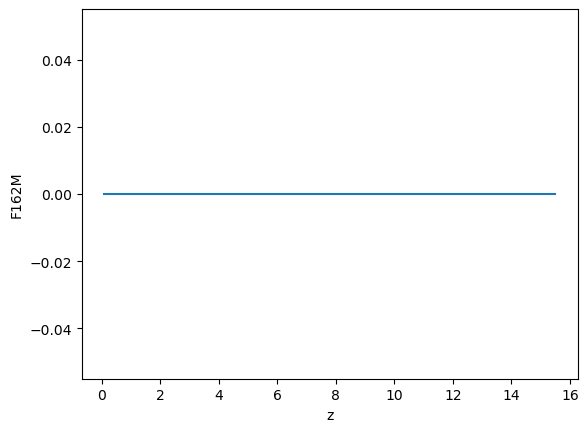

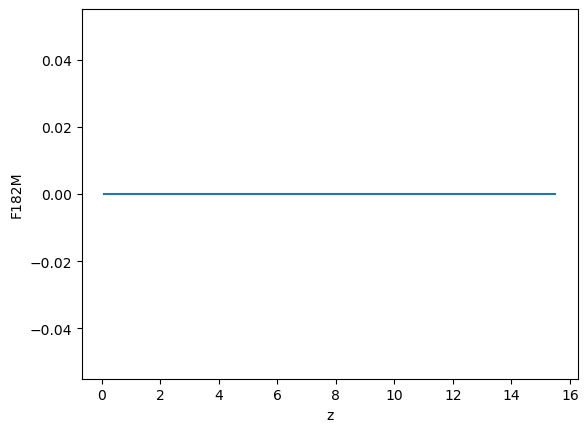

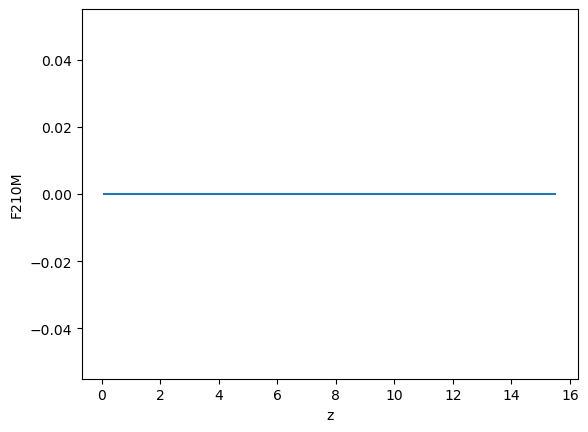

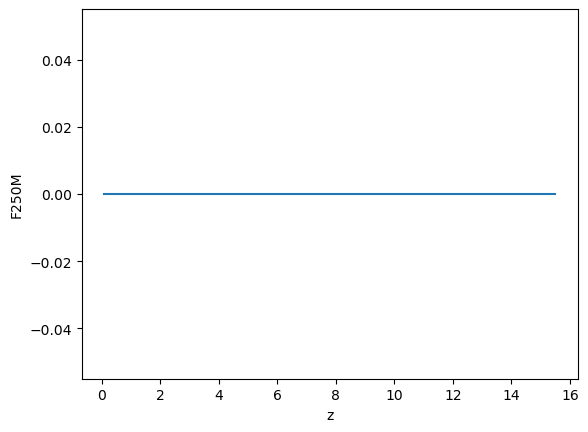

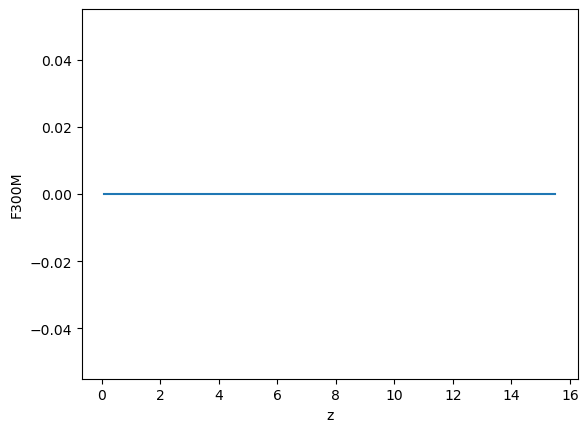

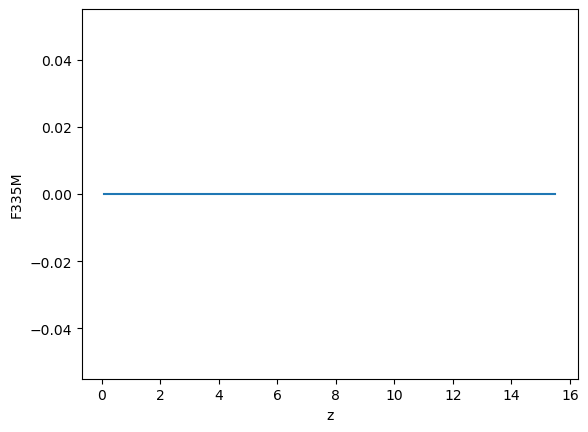

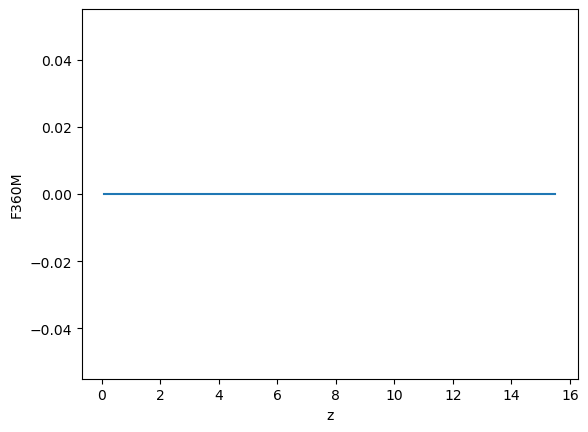

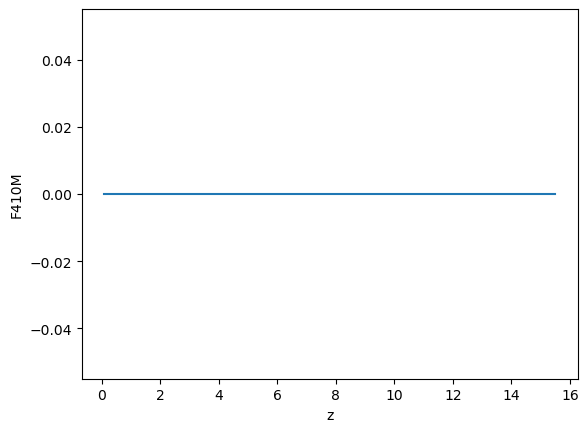

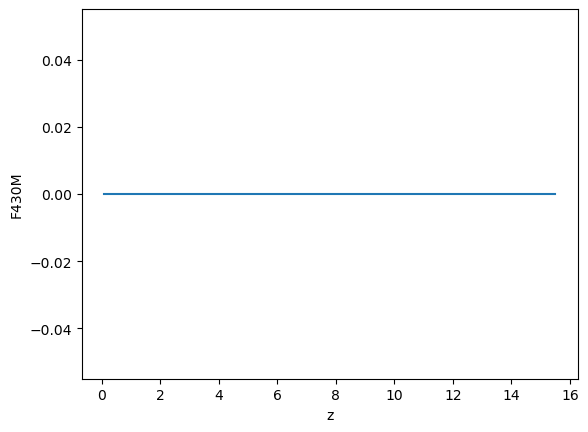

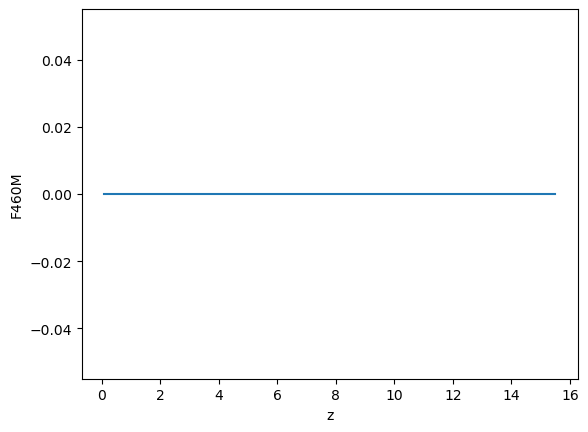

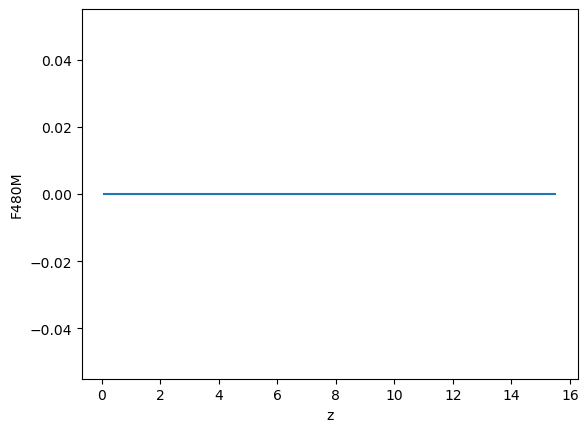

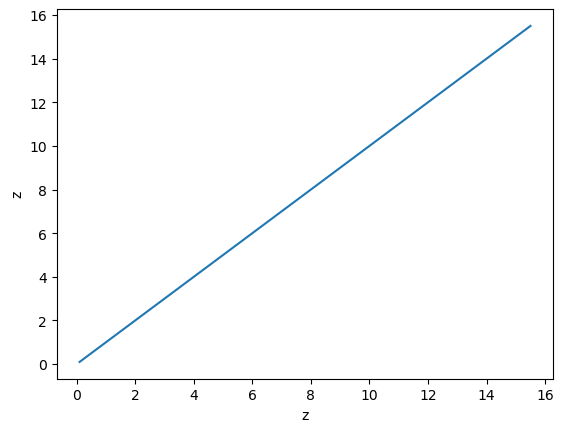

In [25]:
for filt in gal_df.columns:
    plt.plot(zs, gal_df[filt])
    plt.ylabel(filt)
    plt.xlabel('z')
    plt.show()

In [4]:
tde_df

,Unnamed: 0,F070W,F090W,F115W,F150W,F200W,F277W,F356W,F444W,F140M,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,z
0,0,19.212803,19.673325,20.124553,20.640933,21.200791,21.880304,22.396524,22.857347,20.519815,...,21.318801,21.683829,22.054674,22.289823,22.450214,22.697096,22.803574,22.974323,23.046495,0.100000
1,1,24.351105,24.605011,24.915895,25.317797,25.790531,26.397082,26.873362,27.307180,25.218221,...,25.892296,26.217391,26.555606,26.773212,26.922823,27.154856,27.255368,27.417422,27.486160,1.811111
2,2,25.456549,25.467499,25.614580,25.885194,26.259896,26.786193,27.219450,27.624543,25.810658,...,26.343846,26.624965,26.927669,27.126375,27.264444,27.480658,27.574855,27.727720,27.792836,3.522222
3,3,26.404865,26.150881,26.116950,26.242557,26.509523,26.948745,27.336030,27.710716,26.196358,...,26.574314,26.807644,27.072065,27.250556,27.376339,27.575788,27.663324,27.806512,27.867824,5.233333
4,4,27.359368,26.829596,26.603432,26.573688,26.724676,27.070617,27.409149,27.751803,26.558823,...,26.769229,26.951268,27.174785,27.331802,27.444581,27.626345,27.706889,27.839924,27.897250,6.944444
5,5,28.340517,27.530913,27.105973,26.913639,26.941944,27.189092,27.476295,27.785359,26.932761,...,26.965457,27.093068,27.273241,27.407594,27.506687,27.669883,27.743114,27.865532,27.918698,8.655556
6,6,29.347046,28.257148,27.630089,27.270465,27.170846,27.314425,27.547943,27.821939,27.325883,...,27.172789,27.243223,27.377822,27.488400,27.573165,27.716949,27.782563,27.893917,27.942751,10.366667
7,7,30.374309,29.005330,28.174800,27.645096,27.413603,27.449564,27.627281,27.864818,27.738809,...,27.393698,27.404602,27.491615,27.577394,27.647230,27.770807,27.828517,27.928378,27.972714,12.077778
8,8,31.417896,29.771729,28.737536,28.036310,27.670076,27.595056,27.715095,27.914873,28.170058,...,27.628264,27.577663,27.615301,27.675349,27.729702,27.832325,27.881862,27.969821,28.009502,13.788889
9,9,32.474262,30.552994,29.315581,28.442292,27.939315,27.750574,27.811298,27.972115,28.617605,...,27.875722,27.761991,27.748684,27.782161,27.820524,27.901501,27.942616,28.018284,28.053158,15.500000


In [5]:
qso_df

,Unnamed: 0,F070W,F090W,F115W,F150W,F200W,F277W,F356W,F444W,F140M,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,z
0,0,13.251609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100000
1,1,20.453054,20.298076,20.287759,19.985897,19.458586,NaN,NaN,NaN,20.001521,...,19.500168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.811111
2,2,21.940135,21.847546,21.625003,21.541324,21.441335,20.924593,NaN,NaN,21.554272,...,21.380890,21.265337,20.645922,20.743756,NaN,NaN,NaN,NaN,NaN,3.522222
3,3,23.088008,22.663678,22.536294,22.400109,22.202410,22.080982,21.851955,21.368338,22.494854,...,22.184546,22.254056,21.931479,21.950786,21.835434,21.338753,21.504975,NaN,21.355180,5.233333
4,4,NaN,23.449806,23.111452,22.984008,22.784081,22.666019,22.532775,22.309005,23.056316,...,22.744931,22.673742,22.681237,22.652619,22.531684,22.350219,22.391100,22.257958,22.207832,6.944444
5,5,NaN,25.037851,23.674293,23.385566,23.294874,23.012592,23.010911,22.846167,23.500255,...,23.326697,23.107841,23.015993,22.990823,23.017264,22.991708,22.882465,22.703563,22.632012,8.655556
6,6,NaN,NaN,24.802480,23.722909,23.575473,23.439757,23.244439,23.273624,23.614750,...,23.549344,23.604040,23.345480,23.247071,23.275974,23.264007,23.284430,23.320853,23.267856,10.366667
7,7,NaN,NaN,NaN,24.242578,23.900084,23.765345,23.523595,23.497099,24.744200,...,23.751299,23.707502,23.749464,23.600214,23.463594,23.507046,23.466725,23.491948,23.497536,12.077778
8,8,NaN,NaN,NaN,25.188255,24.120202,24.009130,23.874851,23.675181,25.562324,...,24.241220,24.080206,23.994926,23.955021,23.818868,23.660455,23.650610,23.694921,23.657624,13.788889
9,9,NaN,NaN,NaN,NaN,24.515026,24.179674,24.128865,23.894147,NaN,...,24.136453,24.135261,24.164158,24.164461,24.163442,23.978307,23.955456,23.708643,23.830433,15.500000


In [6]:
# z - J, J - W1, W1 - W2
# 900 - 1220, 1220 - 2000, 2000 - 5000

In [7]:
jwst_filters = list(jwst_nircam_limits.keys())

In [8]:
jwst_filters

['F070W',
 'F090W',
 'F115W',
 'F150W',
 'F200W',
 'F277W',
 'F356W',
 'F444W',
 'F140M',
 'F162M',
 'F182M',
 'F210M',
 'F250M',
 'F300M',
 'F335M',
 'F360M',
 'F410M',
 'F430M',
 'F460M',
 'F480M']

In [9]:
#F090W - F115W, F115W - F210M, F210M - F480M

In [10]:
import matplotlib.pyplot as plt

tde_c1 = tde_df['F090W'] - tde_df['F115W']
tde_c2 = tde_df['F115W'] - tde_df['F210M']
tde_c3 = tde_df['F210M'] - tde_df['F480M']

qso_c1 = qso_df['F090W'] - qso_df['F115W']
qso_c2 = qso_df['F115W'] - qso_df['F210M']
qso_c3 = qso_df['F210M'] - qso_df['F480M']



In [ ]:
# ADD 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


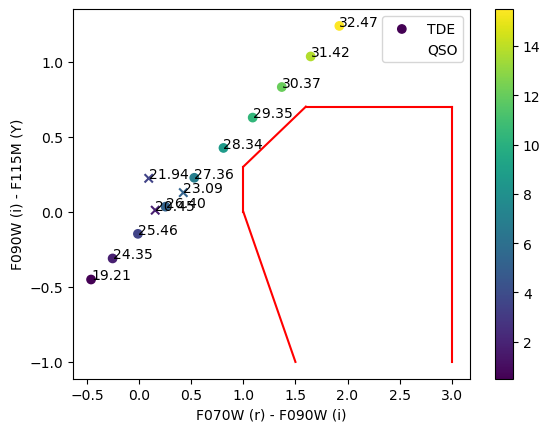

In [37]:
s = plt.scatter(tde_df['F070W'] - tde_df['F090W'], 
                tde_df['F090W'] - tde_df['F115W'], 
                label = 'TDE', c = zs, marker = 'o', norm = normalize)
for i, row in tde_df.iterrows():
    plt.text(row['F070W'] - row['F090W'], 
             row['F090W'] - row['F115W'], 
             '{:.2f}'.format(row['F070W']))
s = plt.scatter(qso_df['F070W'] - qso_df['F090W'], 
                qso_df['F090W'] - qso_df['F115W'], 
                label = 'QSO', c = zs, marker = 'x', norm = normalize)
for i, row in qso_df.iterrows():
    plt.text(row['F070W'] - row['F090W'], 
             row['F090W'] - row['F115W'], 
             '{:.2f}'.format(row['F070W']))
plt.xlabel('F070W (r) - F090W (i)')
plt.ylabel('F090W (i) - F115M (Y)')
plt.plot([3, 3], [-1, 0.7], c = 'r')
plt.plot([1.6, 3], [0.7, 0.7], c = 'r')
plt.plot([1, 1.6], [0.3, 0.7], c = 'r')
plt.plot([1, 1], [0, 0.3], c = 'r')
plt.plot([1, 1.5], [0, -1], c = 'r')
plt.colorbar(s)
plt.legend()
plt.show()

In [14]:
zs

array([  0.1       ,   1.81111111,   3.52222222,   5.23333333,
         6.94444444,   8.65555556,  10.36666667,  12.07777778,
        13.78888889,  15.5       ])

In [15]:
from matplotlib import colors

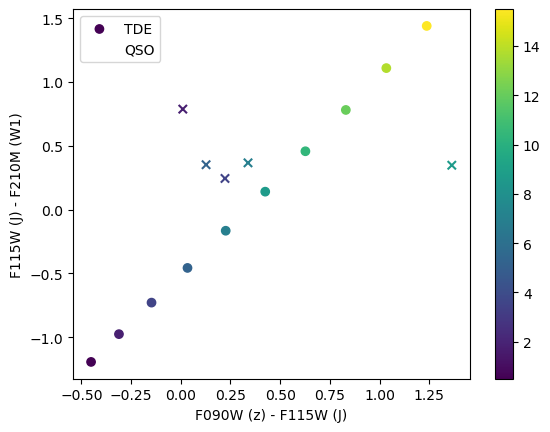

In [16]:
zs = np.linspace(0.1, 15.5, 10)
normalize = colors.Normalize(vmin=0.5, vmax=15.5)

s = plt.scatter(tde_c1, tde_c2, label = 'TDE', c = zs, marker = 'o', norm = normalize)
plt.scatter(qso_c1, qso_c2, label= 'QSO', marker = 'x', c = zs, norm = normalize)
plt.xlabel('F090W (z) - F115W (J)')
plt.ylabel('F115W (J) - F210M (W1)')
plt.colorbar(s)
plt.legend()
plt.show()

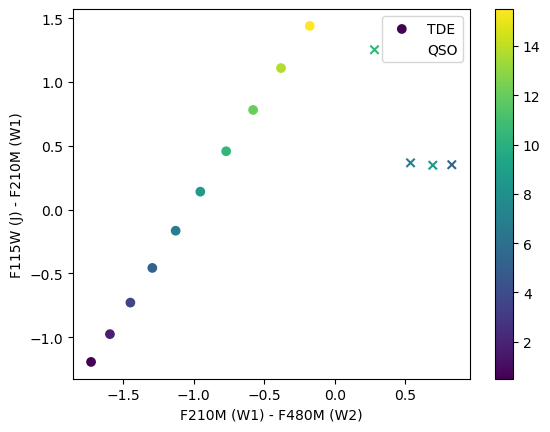

In [35]:
s = plt.scatter(tde_c3, tde_c2, label = 'TDE', c = zs, marker = 'o', norm = normalize)
plt.scatter(qso_c3, qso_c2, label= 'QSO', c = zs, marker = 'x', norm = normalize)
plt.xlabel('F210M (W1) - F480M (W2)')
plt.ylabel('F115W (J) - F210M (W1)')
plt.legend()
plt.colorbar(s)
plt.show()

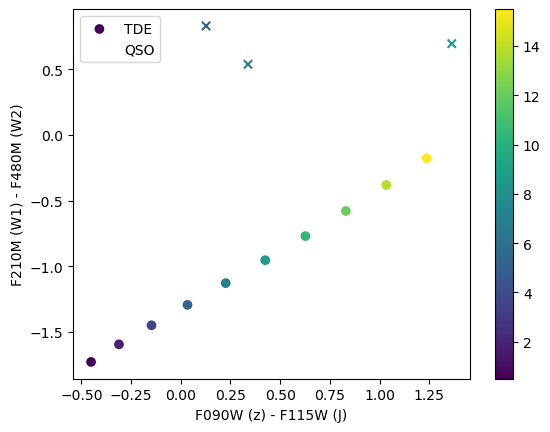

In [36]:
s = plt.scatter(tde_c1, tde_c3, label = 'TDE', c = zs, marker = 'o', norm = normalize)
plt.scatter(qso_c1, qso_c3, label= 'QSO', c = zs, marker = 'x', norm = normalize)
plt.xlabel('F090W (z) - F115W (J)')
plt.ylabel('F210M (W1) - F480M (W2)')
plt.legend()
plt.colorbar(s)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

jwst_filters = list(jwst_nircam_limits.keys())
nfilters = len(jwst_filters)
fig, axes = plt.subplots(nfilters, nfilters, figsize = [nfilters*5, nfilters*5])
for i in range(nfilters):
    for j in range(nfilters):
        if 
        ax = axes[j][i]
        filt1 = jwst_filters[i]
        filt2 = jwst_filters[j]
        ax.plot(tde_df[filt1], tde_df[filt2], label = 'TDEs', alpha = 0.5)
        ax.plot(qso_df[filt1], qso_df[filt2], label = 'QSOs', alpha = 0.5)
        ax.set_xlabel(filt1)
        ax.set_ylabel(filt2)
        ax.legend()
plt.savefig('jwst_color_plot2.pdf', dpi = 300)
plt.show()